In [34]:
from pandas import Series
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from warnings import filterwarnings
filterwarnings('ignore')

In [35]:
df = pd.read_csv("train.csv")

In [36]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

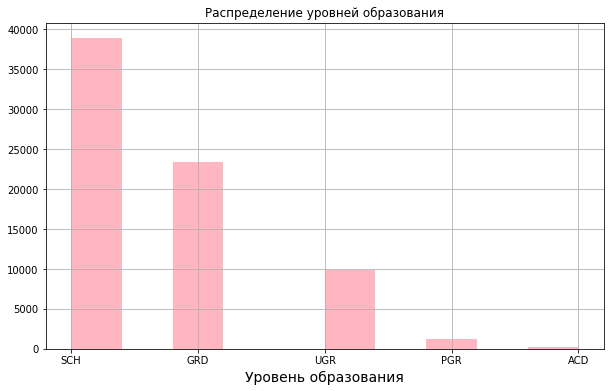

In [38]:
plt.figure(figsize=(10,6))
df.education.hist(color='lightpink')
plt.title('Распределение уровней образования')
plt.xlabel('Уровень образования', {'size': 14});

In [39]:
df.education.fillna("SCH", inplace=True)

In [40]:
# в качестве новых признаков была добавленна сезонность (влияние на )  
seasons = ['winter', 'spring', 'summer', 'autumn']
for season in seasons:
    df[season] = 0

In [41]:
def set_season(row):
    months = {'JAN': 'winter', 'FEB': 'winter', 'DEC': 'winter',
              'MAR': 'spring', 'APR': 'spring', 'MAY': 'spring',
              'JUN': 'summer', 'JUL': 'summer', 'AUG': 'summer',
              'SEP': 'autumn', 'OCT': 'autumn', 'NOV': 'autumn'}
    month = row['app_date'][2:5]
    row[months[month]] = 1
    return row

In [42]:
df = df.apply(set_season, axis=1)

In [43]:
def set_car_type(row):
    car = row['car']
    if car == 'Y':
        car_type = row['car_type']
        if car_type == 'Y':
            return 2
        return 1
    return 0

In [44]:
df['new_car'] = df.apply(set_car_type, axis=1)
# тут под new_car имеется в виду какой авто имеется иномарка или нет

In [45]:
def age_to_cat(age):
    if age <= 28:
        cat_age = 0
        return cat_age             
    if 28 < age <= 35:
        cat_age = 1
        return cat_age
    if 35 < age <= 50:
        cat_age = 2
        return cat_age
    if age > 50:
        cat_age = 3
        return cat_age

In [46]:
df['new_age'] = df.age.apply(age_to_cat)
# тут под new_age я разбиваю клиентов на возрастные группы 

In [47]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,winter,spring,summer,autumn,new_car,new_age
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,4,1,N,0,1,0,0,0,2,3
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,4,1,N,0,0,1,0,0,0,3
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,1,4,Y,0,1,0,0,0,1,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,1,3,N,0,1,0,0,0,0,3
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,1,4,Y,0,0,1,0,0,0,2


In [48]:
num_cols = ["income", "new_age", "bki_request_cnt","decline_app_cnt","score_bki", "region_rating","sna","first_time", 'new_car']
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] + seasons 
cat_cols = ["education", "home_address", "work_address"]

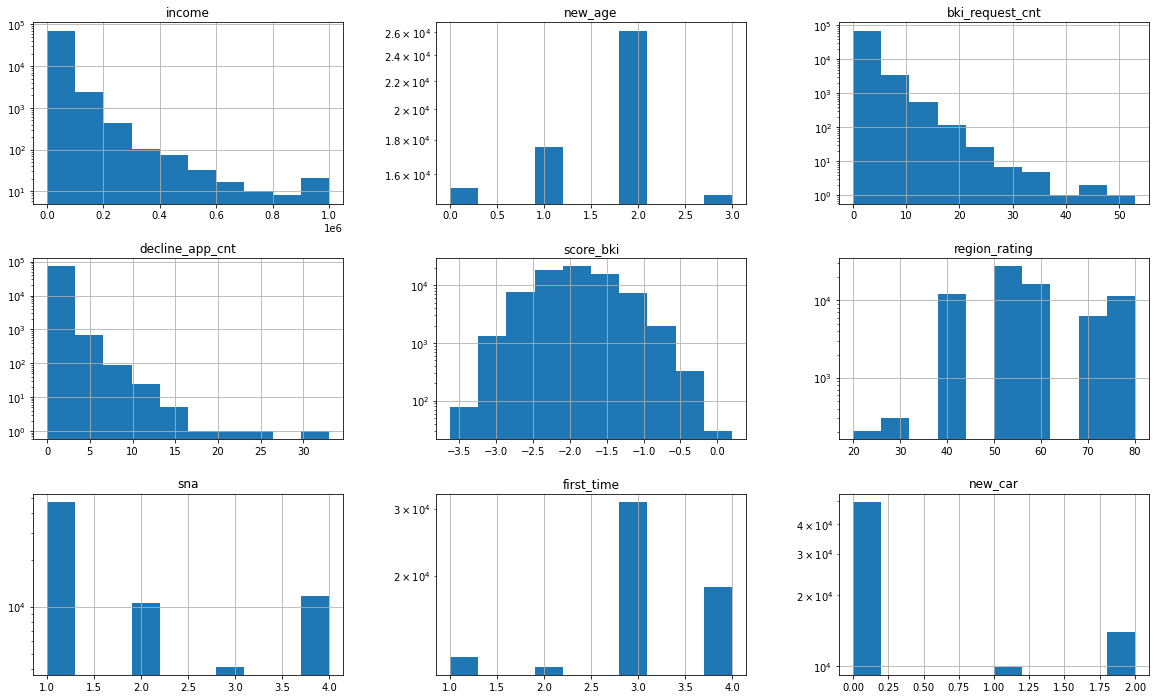

In [49]:
# for i in num_cols:
#     plt.figure()
#     sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
#     plt.title(i)
#     plt.show()

df[num_cols].hist(log=True, figsize=(20, 12));

In [50]:
df = df[(df.income <= 900000) & (df.region_rating > 30) & (df.decline_app_cnt < 20) & (df.age < 65)]

In [51]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,winter,spring,summer,autumn,new_car,new_age
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,4,1,N,0,1,0,0,0,2,3
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,4,1,N,0,0,1,0,0,0,3
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,1,4,Y,0,1,0,0,0,1,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,1,3,N,0,1,0,0,0,0,3
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,1,4,Y,0,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,...,4,4,N,0,0,1,0,0,0,2
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,...,1,4,N,0,0,1,0,0,2,2
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,...,2,2,N,0,0,1,0,0,0,1
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,...,2,3,N,1,1,0,0,0,0,1


In [52]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [53]:
levels = ["ACD", "PGR", "UGR", "GRD", "SCH"]
for level in levels:
    df.loc[df.education==level,"education"] = levels.index(level)

In [54]:
c = df[num_cols].corrwith(df["default"]).abs()

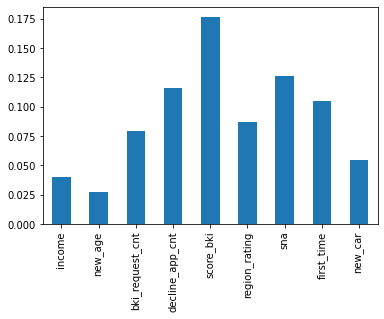

In [55]:
c.plot.bar();

In [56]:
# cols = ['age', 'region_rating'] # "income"]
# for col in cols:
#     num_cols.remove(col)

In [57]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
X_num = StandardScaler().fit_transform(df[num_cols].values)
X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)

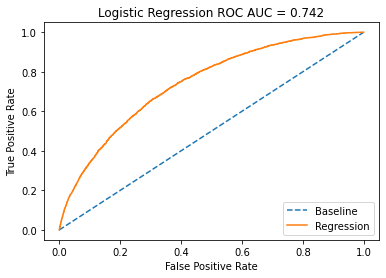

In [59]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [60]:
y_pred = model.predict(X_test)

In [61]:
cf_matrix = confusion_matrix(y_test, y_pred)

In [62]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(dpi=120)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

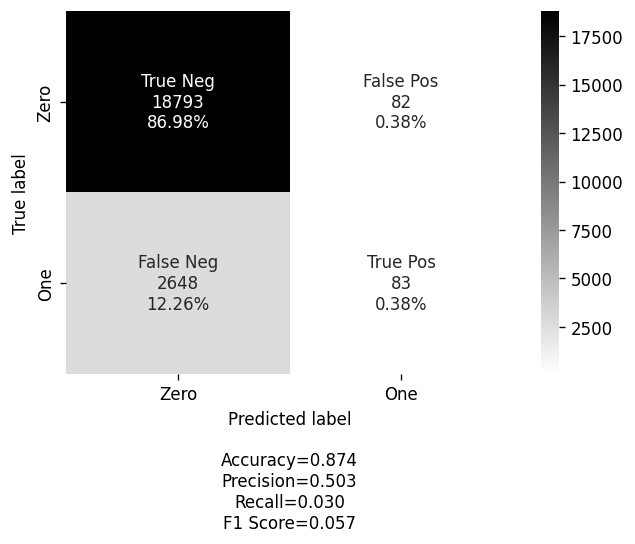

In [63]:
labels = ['True Neg','False Pos','False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [64]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])



Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


In [66]:
df.to_csv('submisison.csv')